### Demonstration of notebook functionality

#### Setting up your Python Environment

In [ ]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct
#from IPython.display import display

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# pyspch
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git@v0.6
except:
  IN_COLAB = False

# pyspch
import pyspch
import pyspch.nn
logging.basicConfig(level=logging.INFO)

In [ ]:
#@title Auxiliary functions 

import requests
import importlib
import scipy.io as sio
import urllib.request
import pickle
import gzip

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

# loads all data in a matlab file at given url to the contents structure
# this is working for MATLAB 7.0 files and older ; not hdf5 MATLAB 7.3 or more recent
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)

In [ ]:
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

#### The TIMIT database 

The experiments in this notebook use the TIMIT database.
Instead of starting from raw speech, we already extracted features (24 filterbank energies) from the speech signal. The feature is obtained by applying the FFT transform (**window step** = 10ms, window size = 30ms, window = Hamming, ...) and mel scaling to the speech waveform (16kHz). Note the window step determines the frame duration (10ms).

The directory structure is as follows:
- audio (.wav)
    - ...
- conf
    - train_corpus.lst
    - test_corpus.lst
    - dummy_corpus.lst
    - meta.tsv
- features (.npy)
    - mel24
        - ...
    - mel80
    - mfcc13
- segmentations (.phn, .wrd, .txt)
    - ...

    
The phone mapping translates the 61 phone labels used by TIMIT to a smaller phone set with 48 (or 39) phone labels.
For example, the 61 phone set discriminates between different types of silences (bcl, dcl, epi, h#, ...), whereas the 39 phone set maps all these to a single silence-label (sil).


#### Setup 

From paths, to feature extraction, to model architecture and training

In [ ]:
# define setup (and root url)
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
use_setup = True
overwrite_setup = False

# load setup
if use_setup:
    setup_file = root_url + 'models/ffdnn_default_mel24dd2v/sig_drop01_adamw0001/setup.py'
    write_from_url(setup_file, 'setup.py')
    setup = read_setup('setup.py')
else:
    setup = dotdict()
    # corpus
    setup.train_corpus_file = root_url + 'conf/timit_train_dummy.corpus'
    setup.test_corpus_file = root_url + 'conf/timit_test.corpus' 
    # features
    setup.feature_path = root_url + 'features/mel24/'
    setup.feature_args =  {
        'spg': None,
        'Deltas': 'delta_delta2',
        'Norm': 'var',
        'sample_rate': 16000,
        'f_shift': 0.01,
        'f_length': 0.03,
        'preemp': 0.97,
        'window': 'hamm',
        'mode': 'dB',
        'n_mels': 24,
        'n_cep': None
    }
    # pickled dataframe (preprocessed)
    setup.train_pickle_file = setup.feature_path + 'train.pkl'
    setup.test_pickle_file = setup.feature_path + 'test.pkl'
    # labels
    setup.label_path =  root_url + 'segmentation/'
    setup.label_args = {
        'extension': '.phn', 
        'pad': 'h#',
        }
    setup.labset_in = "timit61"
    setup.labset_out = "timit41"
    # meta labels
    setup.meta_label_args = None
    # SpchDataset
    setup.sampler_args = {
        'N': 5,
        'stride': 2,
        'mode': 'flatten1d',
        }
    # model
    setup.model_args = {
        'model': 'ffdnn',
        'model_args': {
            'in_dim': 24 * 3 * 11,
            'out_dim': 41,
            'hidden_layer_dims': [1024, 768, 512],
            'nonlinearity': 'sig',
            'dropout': 0.1
            }
        }
    setup.use_cuda_if_available = True
    # training
    setup.current_epoch = 0
    setup.print_every = 1
    setup.training_args = {
        'n_epoch': 250,
        'patience': 20,
        'criterion': 'crossentropy',
        'criterion_args': {},
        'optimizer': 'adamw',
        'optimizer_args': {
            'lr': 0.001,
            },
        'scheduler': 'plateau',
        'scheduler_args': {
            'factor': 0.1,
            'patience': 10,
            'threshold': 0.0001
            },
        'clip_args': {},
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 0,
        'val_frac': 0.1,
        'val_seed': 1234,
        }
    # evaluate
    setup.evaluate_args = {
        'batch_size': 256,
        'shuffle': False,
        'num_workers': 0,
        }
    # output
    setup.output_path = root_url + "models/ffdnn_default_mel24dd2v/sig_drop01_adamw0001/"
    setup.setup_jsonfile = setup.output_path + "setup.json"
    setup.model_file = setup.output_path + "model.pt"
    
# overwrite setup
if use_setup and overwrite_setup:
    # use dummy training data
    setup.train_corpus_file = root_url + 'conf/timit_train_dummy.corpus'
    # smaller model 
    setup.model_args['model_args'].update({
        'hidden_layer_dims': [256, 256]
        })

In [ ]:
# dummy setup (and root url)
root_url = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
setup_file = root_url + 'models/dummy/setup.py'
write_from_url(setup_file, 'setup.py')
setup = read_setup('setup.py', root_url)

#### Data loading

In [ ]:
# load corpus 
train_corpus = pyspch.read_txt(setup.train_corpus_file)
test_corpus = pyspch.read_txt(setup.test_corpus_file)

WARNING(read_data_file): reading from file https://homes.esat.kuleuven.be/~spchlab/data/timit/conf/timit_train_dummy.corpus failed


In [ ]:
# feature arguments
read_feature_args = pyspch.read_json(setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, setup.feature_args)

# features depend on directory, labels are always TIMIT61
train_df = pd.read_pickle(setup.train_pickle_file)
test_df = pd.read_pickle(setup.test_pickle_file)
train_data = pyspch.nn.DataFrame_to_SpchData(train_df, delete_df=True)
test_data = pyspch.nn.DataFrame_to_SpchData(test_df, delete_df=True) 

# subset
train_data = train_data.subset(train_corpus)
test_data = test_data.subset(test_corpus)

# modify features
train_data.modify_features(modify_feature_args)
test_data.modify_features(modify_feature_args)

# set lengths
train_data.lengths = train_data.get_length('features')
test_data.lengths = test_data.get_length('features')

In [ ]:
# label mapping and meta labels
labels = pyspch.timit.get_timit_alphabet(setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(setup.labset_in, setup.labset_out) 
lab2idx = {k: i for i, k in enumerate(labels)} 
print(lab2idx)

{'aa': 0, 'ae': 1, 'ah': 2, 'ao': 3, 'aw': 4, 'er': 5, 'ay': 6, 'b': 7, 'ch': 8, 'd': 9, 'dh': 10, 'eh': 11, 'm': 12, 'ng': 13, 'ey': 14, 'f': 15, 'g': 16, 'hh': 17, 'ih': 18, 'iy': 19, 'jh': 20, 'k': 21, 'l': 22, 'n': 23, 'ow': 24, 'oy': 25, 'p': 26, 'r': 27, 's': 28, 'sh': 29, 't': 30, 'th': 31, 'uh': 32, 'uw': 33, 'v': 34, 'w': 35, 'y': 36, 'z': 37, 'zh': 38, 'sil': 39, 'cl': 40}


In [ ]:
# SpchDataset
train_ds = pyspch.nn.SpchDataset(train_data.corpus, train_data.features, train_data.labels)
test_ds = pyspch.nn.SpchDataset(test_data.corpus, test_data.features, test_data.labels)

# targets  
train_ds.map_target(lab2lab)
train_ds.encode_target(lab2idx)
train_ds.to_tensor()
test_ds.map_target(lab2lab)
test_ds.encode_target(lab2idx)
test_ds.to_tensor()

# sampler with splicing
print(setup.sampler_args)
train_ds.set_sampler(train_data.lengths, setup.sampler_args)
test_ds.set_sampler(test_data.lengths, setup.sampler_args)

{'N': 5, 'stride': 2, 'mode': 'flatten'}


In [ ]:
# free-up memory
rm_data = False
if rm_data:
    del train_data
    del test_data

#### Model training

In [ ]:
# model
print(setup.model_args)
model = pyspch.nn.get_model(setup.model_args)
print(model)

{'model': 'ffdnn', 'model_args': {'in_dim': 792, 'out_dim': 41, 'hidden_layer_dims': [1024, 768, 512], 'nonlinearity': 'sig', 'dropout': 0.1}}
FFDNN(
  (net): Sequential(
    (0): Linear(in_features=792, out_features=1024, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=768, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=768, out_features=512, bias=True)
    (7): Sigmoid()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=512, out_features=41, bias=True)
  )
)


In [ ]:
# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"
    
model.to(device)
train_ds.to_device(device)
test_ds.to_device(device)

In [ ]:
# training
training_args = setup.training_args
print(training_args)

# criterion + optimizer + learning rate-scheduler
criterion = pyspch.nn.get_criterion(training_args)
optimizer = pyspch.nn.get_optimizer(training_args, model) 
scheduler = pyspch.nn.get_scheduler(training_args, optimizer)

# validation set (split fraction from train set)
valid_ds, actual_train_ds = train_ds.split(training_args['val_frac'], training_args['val_seed'])
if valid_ds: print(" %d training examples, %d validation files" % (len(train_ds), len(valid_ds)))    
    
# dataloader (train set)
train_dl = torch.utils.data.DataLoader(actual_train_ds, 
    batch_size=training_args['batch_size'],
    shuffle=training_args['shuffle'], 
    num_workers=training_args['num_workers'])

# dataloader (validation set)
if valid_ds is None:
    valid_dl = None
else:
    valid_dl = torch.utils.data.DataLoader(valid_ds, 
        batch_size=training_args['batch_size'],
        shuffle=training_args['shuffle'], 
        num_workers=training_args['num_workers'])

# test logging
logging.info("start training")

# train model 
current_epoch = setup.current_epoch
print_every = setup.print_every
clip_args = training_args['clip_args']
training_args['n_epoch'] = 10

# train
tr_loss, val_loss, last_epoch = pyspch.nn.train(model, train_dl, criterion, optimizer, 
    clip_args=clip_args, scheduler=scheduler,
    current_epoch=current_epoch, n_epochs=training_args['n_epoch'],
    valid_dl=valid_dl, patience=training_args['patience'], 
    every=print_every)

setup.current_epoch = last_epoch

INFO:root:start training


{'n_epoch': 250, 'patience': 20, 'criterion': 'crossentropy', 'criterion_args': {}, 'optimizer': 'adamw', 'optimizer_args': {'lr': 0.001}, 'scheduler': 'plateau', 'scheduler_args': {'factor': 0.1, 'patience': 10, 'threshold': 0.0001}, 'clip_args': {}, 'batch_size': 64, 'shuffle': True, 'num_workers': 0, 'val_frac': 0.1, 'val_seed': 1234}
 1461 training examples, 146 validation files


INFO:root:Epoch 0 -- av. train loss per mini-batch 3.37
INFO:root:	 -- av. validation loss per mini-batch 3.21
INFO:root:Epoch 1 -- av. train loss per mini-batch 3.02
INFO:root:	 -- av. validation loss per mini-batch 2.89
INFO:root:Epoch 2 -- av. train loss per mini-batch 2.69
INFO:root:	 -- av. validation loss per mini-batch 2.51
INFO:root:Epoch 3 -- av. train loss per mini-batch 2.40
INFO:root:	 -- av. validation loss per mini-batch 2.46
INFO:root:Epoch 4 -- av. train loss per mini-batch 2.12
INFO:root:	 -- av. validation loss per mini-batch 2.42
INFO:root:Epoch 5 -- av. train loss per mini-batch 1.85
INFO:root:	 -- av. validation loss per mini-batch 2.11
INFO:root:Epoch 6 -- av. train loss per mini-batch 1.65
INFO:root:	 -- av. validation loss per mini-batch 1.86
INFO:root:Epoch 7 -- av. train loss per mini-batch 1.50
INFO:root:	 -- av. validation loss per mini-batch 1.90
INFO:root:Epoch 8 -- av. train loss per mini-batch 1.37
INFO:root:	 -- av. validation loss per mini-batch 1.83
I

#### Model evaluation

##### Test set

In [ ]:
# test dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

PER 0.63 
CEL 2.79


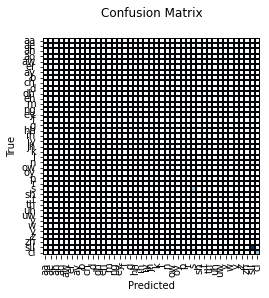

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [ ]:
# Confusion matrix
cm = pyspch.nn.evaluate_cm(model, test_dl) 

# Phone Error Rate (PER) + PER per phone class
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
if not None in per_pc:
    print("PER per phone class %s" % (np.round(per_pc, 4)))

# Cross-entropy loss
loss = pyspch.nn.evaluate(model, test_dl, criterion)
print("CEL %.2f" % loss)

# plot
pyspch.plot_confusion_matrix(cm, labels, annot=False)

##### Single utterance

In [ ]:
# select file to visualize
example = 'test/dr1/faks0/si2203'

# transcription + word segmentation 
example_txt = pyspch.read_txt(setup.label_path + example + ".txt")
example_wrd = pyspch.read_dataframe(setup.label_path + example + ".wrd", sep=" ", names=['t0','t1','wrd'])

# labels (phone segmentation)
lab_shift = read_feature_args['f_shift'] * read_feature_args['sample_rate']
example_phn = pyspch.timit.read_seg_file(setup.label_path + example + ".phn", fmt="float32")
example_lab = pyspch.seg2lbls(example_phn, lab_shift)
example_lab = [lab2lab[lbl] for lbl in example_lab]
example_idx = [lab2idx[lbl] for lbl in example_lab] # target

# audio
example_audio, _ = pyspch.audio.load(root_url + 'audio/' + example + ".wav", sample_rate=lab_shift)

# feature + modification + splicing
example_feature = np.load(pyspch.read_fobj(setup.feature_path + example + '.npy'))
example_mod = pyspch.sp.feature_extraction(spg=example_feature, **modify_feature_args)
example_spliced = pyspch.sp.splice_frames(example_mod, setup.sampler_args['N'], setup.sampler_args['stride']) # input

# tensor
example_X = torch.tensor(example_spliced).T.float().to(device)
example_y = torch.tensor(example_idx).long().to(device)

In [ ]:
# output for single example utterance 
example_yp = model(example_X) # log probs
example_yp = torch.nn.Softmax(dim=1)(example_yp) # probs

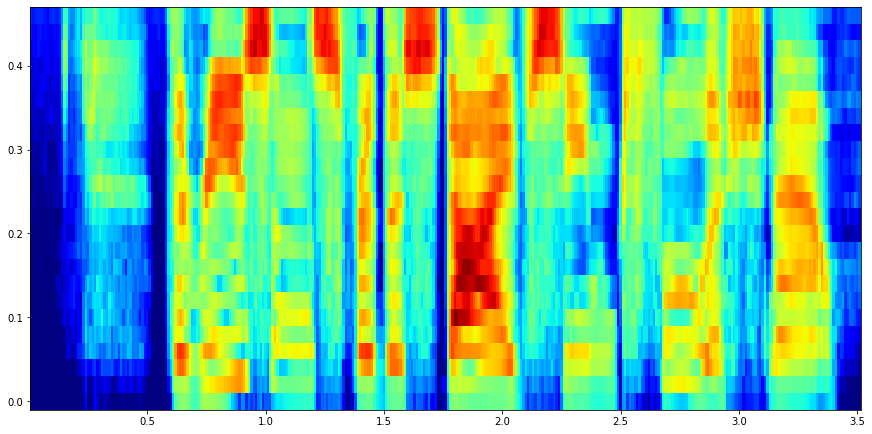

In [ ]:
pyspch.display.PlotSpg(spgdata=example_feature, segspg=example_phn)

#### Model write/read

In [ ]:
# write checkpoint
model_file = "model_eval.pt"
pyspch.nn.write_checkpoint(model_file, setup, lab2idx, model, optimizer, scheduler)

# read checkpoint
model_setup, lab2idx, model, criterion, optimizer, scheduler = pyspch.nn.read_checkpoint(model_file, device)
model = pyspch.nn.get_model(model_setup['model_args'])

# test model 
# -- new setup
new_setup = setup.copy()
new_setup.update(model_setup)
new_setup = dotdict(new_setup)

# feature arguments
feature_path = root_url + 'features/mel24/'
read_feature_args = pyspch.read_json(new_setup.feature_path + 'feature_args.json')
modify_feature_args = pyspch.dct_diff(read_feature_args, new_setup.feature_args)

# Data
dummy_df = pd.read_pickle(new_setup.train_pickle_file)
dummy_data = pyspch.nn.DataFrame_to_SpchData(dummy_df, delete_df=True)
dummy_data = dummy_data.subset(train_corpus)
dummy_data.modify_features(modify_feature_args)
dummy_data.lengths = dummy_data.get_length('features')

# SpchDataset
labels = pyspch.timit.get_timit_alphabet(new_setup.labset_out)
lab2lab = pyspch.timit.get_timit_mapping(new_setup.labset_in, new_setup.labset_out) 
dummy_ds = pyspch.nn.SpchDataset(dummy_data.corpus, dummy_data.features, dummy_data.labels)
dummy_ds.map_target(lab2lab)
dummy_ds.encode_target(lab2idx)
dummy_ds.to_tensor()
dummy_ds.set_sampler(dummy_data.lengths, new_setup.sampler_args)

# device
model.to(device)
dummy_ds.to_device(device)

PER 0.98 
CEL 4.29


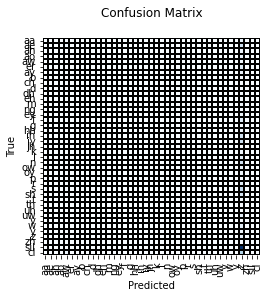

(<Figure size 288x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Confusion Matrix\n'}, xlabel='Predicted', ylabel='True'>)

In [ ]:
# evaluate
loss = pyspch.nn.evaluate(model, test_dl, criterion)
cm = pyspch.nn.evaluate_cm(model, test_dl) 
per, per_pc = pyspch.nn.cm2per(cm)
print("PER %.2f " % (per))
print("CEL %.2f" % loss)
pyspch.plot_confusion_matrix(cm, labels, annot=False)

In [ ]:
# continued training
training_args = new_setup.training_args

# criterion + optimizer + learning rate-scheduler
criterion = pyspch.nn.get_criterion(training_args)
optimizer = pyspch.nn.get_optimizer(training_args, model) 
scheduler = pyspch.nn.get_scheduler(training_args, optimizer)

# validation set (split fraction from train set)
valid_ds, actual_train_ds = train_ds.split(training_args['val_frac'], training_args['val_seed'])
if valid_ds: print(" %d training examples, %d validation files" % (len(train_ds), len(valid_ds)))    
    
# dataloader (train set)
train_dl = torch.utils.data.DataLoader(actual_train_ds, 
    batch_size=training_args['batch_size'],
    shuffle=training_args['shuffle'], 
    num_workers=training_args['num_workers'])

# dataloader (validation set)
if valid_ds is None:
    valid_dl = None
else:
    valid_dl = torch.utils.data.DataLoader(valid_ds, 
        batch_size=training_args['batch_size'],
        shuffle=training_args['shuffle'], 
        num_workers=training_args['num_workers'])

# test logging
logging.info("start training")

# train model 
current_epoch = setup.current_epoch
print_every = setup.print_every
clip_args = training_args['clip_args']
training_args['n_epoch'] = 10

# train
tr_loss, val_loss, last_epoch = pyspch.nn.train(model, train_dl, criterion, optimizer, 
    clip_args=clip_args, scheduler=scheduler,
    current_epoch=current_epoch, n_epochs=training_args['n_epoch'],
    valid_dl=valid_dl, patience=training_args['patience'], 
    every=print_every)

setup.current_epoch = last_epoch

INFO:root:start training


 1461 training examples, 146 validation files


INFO:root:Epoch 10 -- av. train loss per mini-batch 3.39
INFO:root:	 -- av. validation loss per mini-batch 3.24
INFO:root:Epoch 11 -- av. train loss per mini-batch 3.13
INFO:root:	 -- av. validation loss per mini-batch 3.04
INFO:root:Epoch 12 -- av. train loss per mini-batch 2.83
INFO:root:	 -- av. validation loss per mini-batch 2.60
INFO:root:Epoch 13 -- av. train loss per mini-batch 2.54
INFO:root:	 -- av. validation loss per mini-batch 2.57
INFO:root:Epoch 14 -- av. train loss per mini-batch 2.25
INFO:root:	 -- av. validation loss per mini-batch 2.47
INFO:root:Epoch 15 -- av. train loss per mini-batch 1.99
INFO:root:	 -- av. validation loss per mini-batch 2.23
INFO:root:Epoch 16 -- av. train loss per mini-batch 1.79
INFO:root:	 -- av. validation loss per mini-batch 1.97
INFO:root:Epoch 17 -- av. train loss per mini-batch 1.59
INFO:root:	 -- av. validation loss per mini-batch 1.94
INFO:root:Epoch 18 -- av. train loss per mini-batch 1.46
INFO:root:	 -- av. validation loss per mini-bat